# ism3d.uvhelper: visibility imaging 

## Setup

We first import essential API functions / modules from `ism3d` and other libraries

**Used ISM3D Functions:**

* `im3d.logger.logger_config`
* `im3d.logger.logger_status`

In [47]:
nb_dir=_dh[0]
os.chdir(nb_dir+'/../output/mockup')
sys.path.append(nb_dir)
from notebook_setup import *

%matplotlib inline
%config InlineBackend.figure_format = "png" #  ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%reload_ext wurlitzer
%reload_ext memory_profiler
%reload_ext line_profiler

ism3d.logger_config(logfile='ism3d.log',loglevel='INFO',logfilelevel='INFO',log2term=False)

print(''+ism3d.__version__)
print('working dir: {}\n'.format(os.getcwd()))

0.3.dev1
working dir: /Users/Rui/Resilio/Workspace/projects/ism3d/models/output/mockup



## Data Import 

We import the visibility data from CASA measurement sets into the internal `uvdata` variable (essential a simple nested dict, not class yet) and also save them into compressed HDF5 for compact storage and easy retrieve.

Here three ALMA/VLA datasets are used:

* mockup1:  based on the VLA GN20 observation 1-channel
* mockup2:  based on the ALMA G09 observation 1-channel
* mockup3:  based on the ALMA G09 observation 240-channel, only 2mins integration
* mockup3:  based on the ALMA G09 observation 240-channel, all on-source data

**Used ISM3D Functions:**

* `im3d.uvhelper.io.to_hdf5`
* `ism3d.uvhelper.ms.rmPointing`
* `ism3d.uvhelper.ms.read_ms`

In [ ]:
os.system('rm -rf '+'mockup1_basis.ms')
mstransform(vis='../data/gn20/vla/AC974.100409.ms',outputvis='mockup1_basis.ms',
            spw='0:60',datacolumn='data')

os.system('rm -rf '+'mockup2_basis.ms')
mstransform(vis='../data/g09/alma/bb4.ms',outputvis='mockup2_basis.ms',
            spw='*:60',datacolumn='data')
rmPointing('mockup2_basis.ms',verbose=False)

os.system('rm -rf '+'mockup3_basis.ms')
mstransform(vis='../../data/g09/alma/bb4.ms',outputvis='mockup3_basis.ms',
            spw='',timerange='06:08:00~06:10:00',datacolumn='data')
rmPointing('mockup3_basis.ms',verbose=False)

os.system('rm -rf '+'mockup4_basis.ms')
os.system('ln -s ../../data/g09/alma/bb4.ms '+'mockup4_basis.ms')

for model_name in ['mockup1','mockup2','mockup3','mockup4']:

    # option 1
    #uvdata={}
    #read_ms(vis=model_name+'_basis.ms',dataset=uvdata,keyrule='basename')

    # option 2
    uvdata=read_ms(vis=model_name+'_basis.ms')

    # save to / reterive from .h5
    to_hdf5(uvdata,outname=model_name+'_basis.h5',checkname=False,compression='gzip')    


## Imaging

We image the visibility using two different approched implemented in `ism3d`:
* `ism3d.uvhelper.invert`: a function wrapping around casa.tclean etc. to create dirty maps in an organized fahsion 
* `ism3d.uvhelper.invert_ft`: the same purpose as above, but based on FINUFFT

**Used ISM3D Functions:**

* `ism3d.uvhelper.imager.invert`
* `ism3d.uvhelper.io.from_hdf5`
* `ism3d.uvhelper.invert`
* `ism3d.uvhelper.invert_ft`
* `ism3d.uvhelper.make_psf`
* `ism3d.uvhelper.ft.advise_header`
* `ism3d.xyhelper.cube.hextract`

In [45]:
model_name='mockup4'
uvdata=from_hdf5(model_name+'_basis.h5')

<Figure size 432x288 with 0 Axes>

In [37]:
header=advise_header(uvdata['uvw'],
                    uvdata['phasecenter'],
                    uvdata['chanfreq'],
                    uvdata['chanwidth'],
                    antsize=12*u.m,sortbyfreq=True)

cell=header['CDELT2']<<u.deg
imsize=header['NAXIS1']

print(imsize,cell.to(u.arcsec))

tic= time.time()
invert(vis=model_name+'_basis.ms',
       imagename=model_name+'_basis.images/casa',
       weighting='natural',specmode='cubedata',width='',start='',nchan=-1, # width=-1,start=239,nchan=-1,
       cell=cell.to_value(u.arcsec),imsize=[imsize,imsize],onlydm=False,dropstokes=True)
toc= time.time()
print("Elapsed Time: {:>8.2f} seconds # {} \n".format(toc-tic,'ism3d.uvhelper.imager.invert'))

tic= time.time()
%memit cube=invert_ft(uvdata=uvdata,header=header,sortbyfreq=True).astype(np.float32)
%memit psf=(make_psf(uvdata=uvdata,header=header,sortbyfreq=True)).astype(np.float32)
toc= time.time()
print("Elapsed Time: {:>8.2f} seconds # {} \n".format(toc-tic,'ism3d.uvhelper.ft.invert_ft/.make_psf'))

fits.writeto(model_name+'_basis.images/nufft.image.fits',cube.T,header,overwrite=True)
fits.writeto(model_name+'_basis.images/nufft.psf.fits',psf.T,header,overwrite=True)

for version in ['image','psf']:
    tcube,thdr=fits.getdata(model_name+'_basis.images/casa.'+version+'.fits',header=True)
    cube,hdr=fits.getdata(model_name+'_basis.images/nufft.'+version+'.fits',header=True)
    cube_diff=cube-tcube
    fits.writeto(model_name+'_basis.images/diff.'+version+'.fits',cube_diff,thdr,overwrite=True)

if  model_name=='mockup4' or model_name=='mockup3':
    # get ride of the first plan of mockup4 as it's partially flagged with different PSF.
    for version in ['nufft.image','nufft.psf','casa.image','casa.psf','casa.pb','diff.image','diff.psf']:
        data,header=fits.getdata(model_name+'_basis.images/'+version+'.fits',header=True)
        data_sub,header_sub=hextract(data, header, np.s_[1:,:,:])
        fits.writeto(model_name+'_basis.images/'+version+'.fits',data_sub,header_sub,overwrite=True)


288 0.23221417798405314 arcsec



0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2020-07-06 04:48:23	WARN	task_tclean::SIImageStore::restore (file casa-source/code/synthesis/ImagerObjects/SIImageStore.cc, line 2089)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


Elapsed Time:   331.42 seconds # ism3d.uvhelper.imager.invert 

peak memory: 4260.89 MiB, increment: 538.22 MiB
peak memory: 4390.84 MiB, increment: 129.93 MiB
Elapsed Time:    54.79 seconds # ism3d.uvhelper.ft.invert_ft/.make_psf 



<Figure size 432x288 with 0 Axes>

## Visualize

Here we demostrate the visulization capabiliy of ism3d. Specifically, we plot the results from two imaging appraoching and compare their precisions.

**Used ISM3D Functions:**

* `ism3d.visualize.nb.make_gif`
* `ism3d.visualize.nb.show_gif`
* `ism3d.visualize.plts.im_grid`


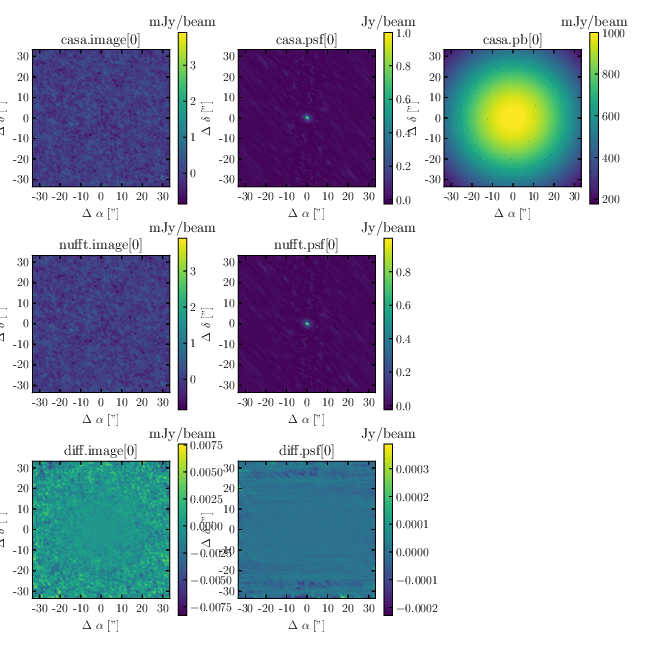

In [44]:
units=[] ; images=[] ; titles=[]; vmaxs=[]; vmins=[]

for version in ['casa.image','casa.psf','casa.pb','nufft.image','nufft.psf',None,'diff.image','diff.psf']:
    if version is not None:
        data,hdr=fits.getdata(model_name+'_basis.images/'+version+'.fits',header=True)
        titles.append(version)
        if 'psf' in titles[-1]:
            images.append(data); units.append("Jy/beam")
        else:
            images.append(data*1e3); units.append("mJy/beam")
        vmaxs.append(np.nanmax(images[-1]))
        vmins.append(np.nanmin(images[-1]))
    else:
        titles.append(None);  images.append(None); units.append(None); vmaxs.append(None); vmins.append(None)
        
       
w = WCS(hdr).celestial
coord = SkyCoord(hdr['CRVAL1'], hdr['CRVAL2'], unit="deg")
offset_w=linear_offset_coords(w,coord)
nchan=hdr['NAXIS3']
stepchan= int(np.maximum(np.floor(int(nchan/5)),1))

fignames=[]
for ichan in range(0,nchan,stepchan):
    
    #clear_output(wait=True)
    figname=model_name+'_basis.images/chmap/ch{:03d}'.format(ichan)+'.pdf'
    images0=[None if image is None else image[ichan,:,:] for image in images]
    titles0=[None if title is None else title+'['+'{}'.format(ichan)+']' for title in titles ]
    im_grid(images0,offset_w,units=units,titles=titles0,nxy=(3,3),figsize=(9,9),figname=figname,vmins=vmins,vmaxs=vmaxs) ;
    fignames.append(figname) 

make_gif(fignames,model_name+'_basis.images/chmap.gif')
show_gif(model_name+'_basis.images/chmap.gif')